In [2]:
library(dplyr)
library(lattice)
library(reshape2)
library(ggplot2)

# Read CSV ----------------------------------------------------------------
airfare <- read.csv("~/notebooks/AirFare/Data/tripRequest.csv", header=TRUE, dec=".", sep=";")

# [DataFrame] Drop double&uncess informtion --------------------------------------
airfare <- subset(airfare, select = -c(requestString,tripRequest_id,requestDate,tripReturn,sliceDuration,tripStart,tripDestination))
airfare <- subset(airfare, select = -c(trip_id.1,trip_id.2,trip_id.3))
airfare <- subset(airfare, select = -c(tripOrder.1,tripOrder.2))
airfare <- subset(airfare, select = -c(tripRequest_id.1))

# Data Formats ------------------------------------------------------------
airfare$package <- as.POSIXct(strptime(airfare$package, "%d-%m-%Y"))
airfare$tripStartDeparture <- as.POSIXct(strptime(airfare$tripStartDeparture, "%Y-%m-%d %H:%M:%S"))
airfare$tripDestinationDeparture <- as.POSIXct(strptime(airfare$tripDestinationDeparture, "%Y-%m-%d %H:%M:%S"))
airfare$arrivalTime <- as.POSIXct(strptime(airfare$arrivalTime, "%Y-%m-%d %H:%M:%S"))
airfare$departureTime <- as.POSIXct(strptime(airfare$departureTime, "%Y-%m-%d %H:%M:%S"))

In [3]:
# Splitting Data into smaller Packages ------------------------------------
#data.fare <- airfare %>% group_by(trip_id) %>% summarise(saleTotal = mean(saleTotal, na.rm=TRUE))
subset.fares <- filter(airfare, marriedSegmentGroup==0) #Only one trip necessary for pricing
subset.fares <- subset.fares %>% select(trip_id, package, tripStartDeparture, flightCarrier, saleTotal, operatingDisclosure) %>% group_by(trip_id)

# output
head(subset.fares)

,trip_id,package,tripStartDeparture,flightCarrier,saleTotal,operatingDisclosure
1,103973,2015-02-24,2015-02-24 13:45:01,KL,477.99,OPERATED BY DELTA
2,103976,2015-02-24,2015-02-24 13:45:01,AF,477.99,OPERATED BY DELTA
3,103977,2015-02-24,2015-02-24 08:20:01,SQ,556.31,NULL
4,103978,2015-02-24,2015-02-24 10:50:01,UA,890.99,OPERATED BY LUFTHANSA
5,103979,2015-02-24,2015-02-24 11:05:01,UA,890.99,NULL
6,103980,2015-02-24,2015-02-24 10:50:01,UA,890.99,OPERATED BY LUFTHANSA


In [4]:
# Adjust Data Frame -------------------------------------------------------------------
df <-subset.fares
df$package = as.POSIXct(df$package, format='%Y/%m/%d')
df$daysBeforeDeparture = as.POSIXct(strftime(df$tripStartDeparture, format="%Y/%m/%d"))

# Difference of request date and actual departure (to see how many days before the flight it was "booked")
df$daysBeforeDeparture = as.factor(round(difftime(df$daysBeforeDeparture, df$package, units="days")))

#x=Days before Deperature
#y=Price(Avg)

df_cleaned <- subset(df, select = -c(package,trip_id,tripStartDeparture))

# remove operated by
df_cleaned$operatingDisclosure <- gsub("\\b(OPERATED|BY )\\b", "", df_cleaned$operatingDisclosure, fixed=FALSE)
df_cleaned$operatingDisclosure <- gsub("[[:space:]]", "", df_cleaned$operatingDisclosure, fixed=FALSE)
df_cleaned$operatingDisclosure <- sub("NULL", NA, df_cleaned$operatingDisclosure, fixed=TRUE)

# combine columns and remove
df_cleaned$carrier <- gsub(", $", "", paste(df_cleaned$flightCarrier, ifelse(is.na(df_cleaned$operatingDisclosure), "*", df_cleaned$operatingDisclosure) ,sep ="_"))
df_cleaned$carrier <- sub("\\_\\*", '', df_cleaned$carrier)
df_cleaned <- subset(df_cleaned, select = -c(operatingDisclosure))

head(df_cleaned, 3)

,flightCarrier,saleTotal,daysBeforeDeparture,carrier
1,KL,477.99,0,KL_DELTA
2,AF,477.99,0,AF_DELTA
3,SQ,556.31,0,SQ


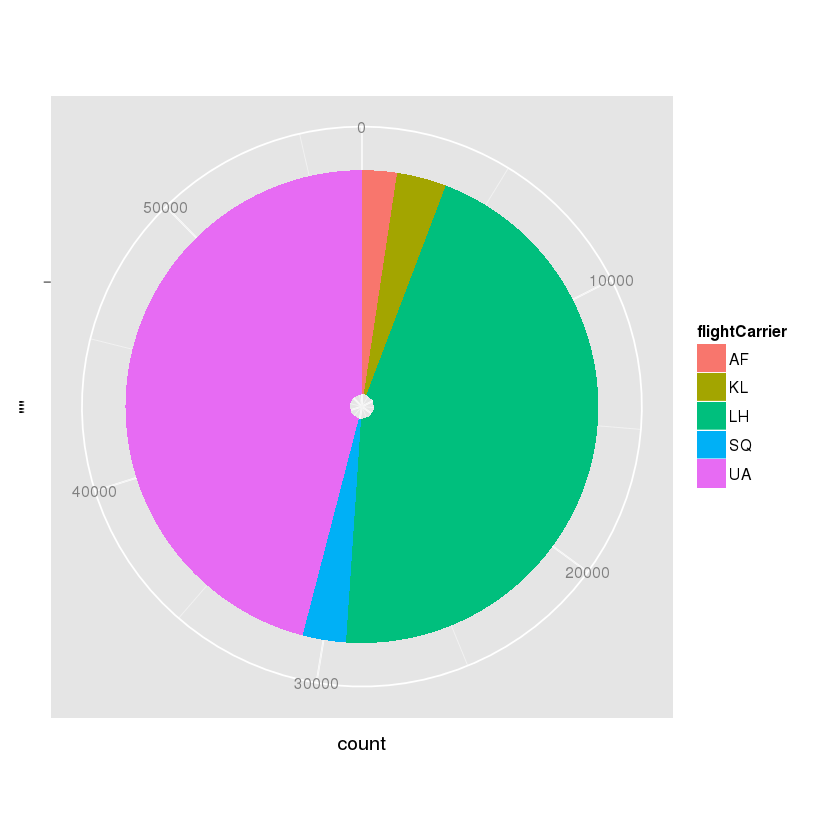

In [5]:
ggplot(df_cleaned, aes(x="", fill=flightCarrier))+geom_bar(width = 0.9)+ coord_polar("y", start=0)

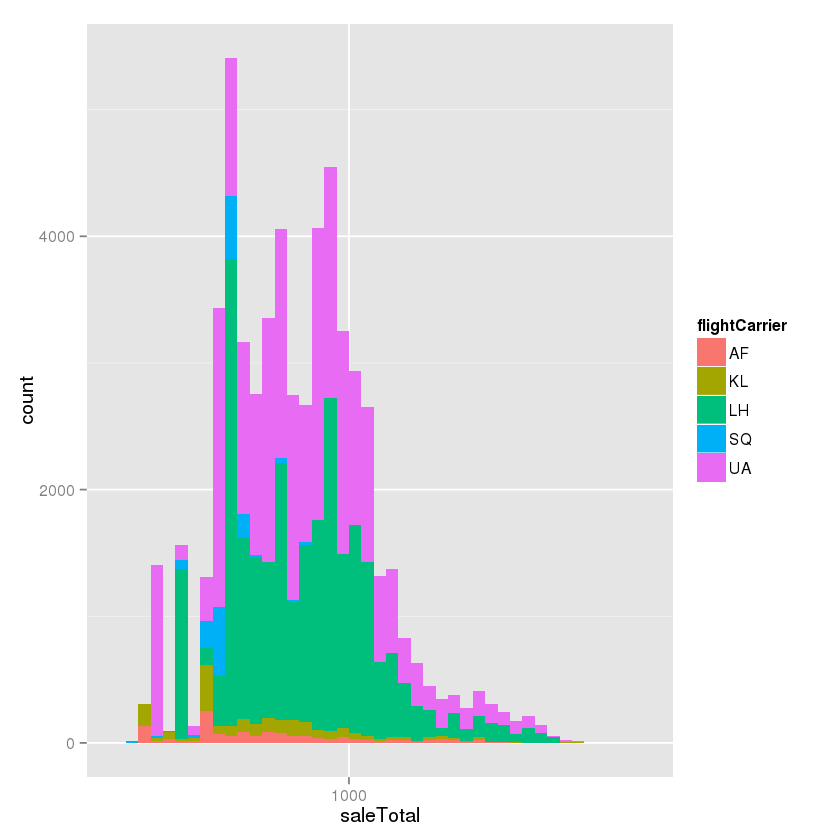

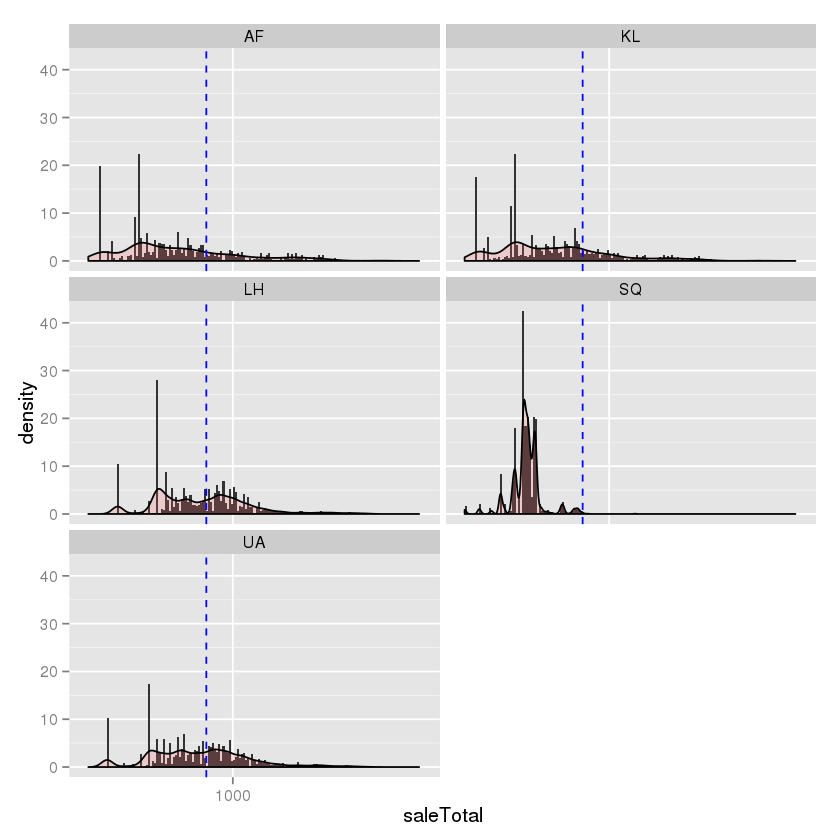

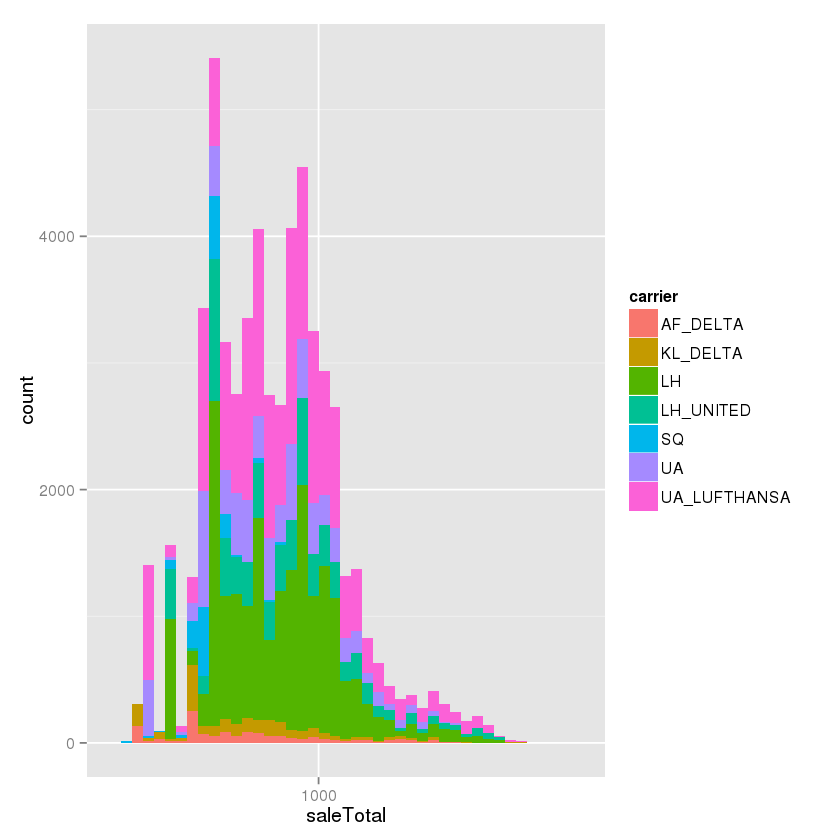

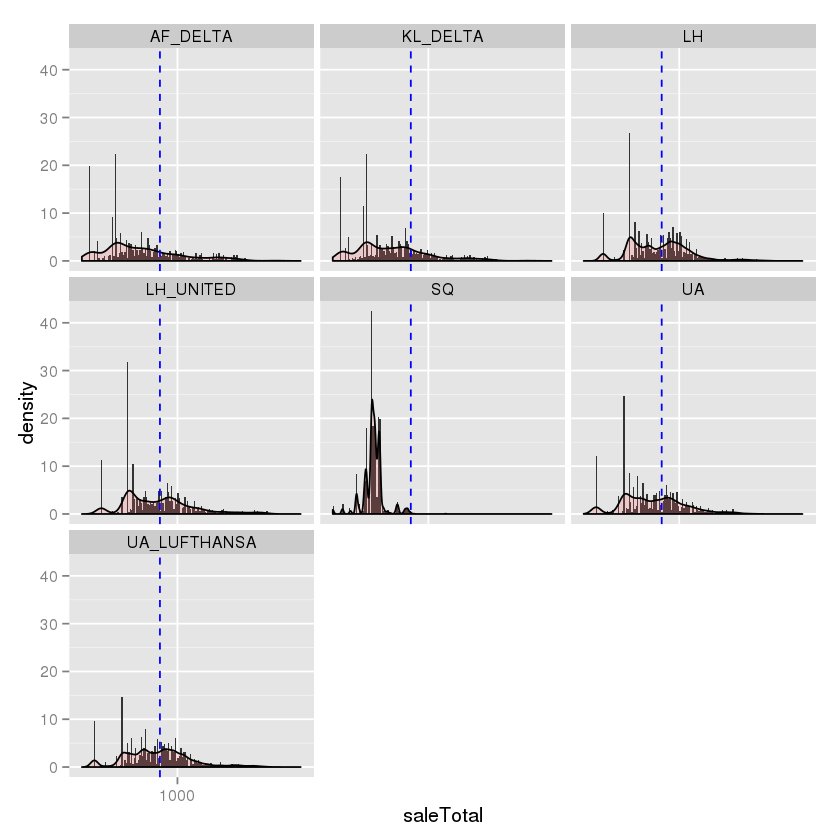

In [6]:
# by flightCarrier
ggplot(df_cleaned, aes(saleTotal, fill = flightCarrier)) + geom_histogram(binwidth = 0.02)+ scale_x_log10()

ggplot(df_cleaned, aes(x=saleTotal))+ 
  geom_histogram(aes(y=..density..), binwidth = 0.005)+
  geom_density(alpha=.2, fill="#FF6666") +
  geom_vline(aes(xintercept=mean(saleTotal)), color="blue", linetype="dashed", size=0.5) +
  facet_wrap(~flightCarrier, nrow = 3)+ scale_x_log10()


# by flightCarrier + interlining
ggplot(df_cleaned, aes(saleTotal, fill = carrier)) + geom_histogram(binwidth = 0.02)+ scale_x_log10()

ggplot(df_cleaned, aes(x=saleTotal))+ 
  geom_histogram(aes(y=..density..), binwidth = 0.005)+
  geom_density(alpha=.2, fill="#FF6666") +
  geom_vline(aes(xintercept=mean(saleTotal)), color="blue", linetype="dashed", size=0.5) +
  facet_wrap(~carrier, nrow = 3)+ scale_x_log10()